In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
df = pd.read_csv('data.csv')
df.sample(5)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
7012,Toyota,MR2 Spyder,2005,regular unleaded,138.0,4.0,AUTOMATED_MANUAL,rear wheel drive,2.0,Performance,Compact,Convertible,30,23,2031,26145
9385,GMC,Sierra 1500,2017,flex-fuel (unleaded/E85),285.0,6.0,AUTOMATIC,four wheel drive,2.0,Flex Fuel,Large,Regular Cab Pickup,22,17,549,32145
10052,GMC,Suburban,1997,regular unleaded,255.0,8.0,AUTOMATIC,rear wheel drive,4.0,NaN,Large,4dr SUV,17,12,549,2468
1982,Chevrolet,Blazer,2005,regular unleaded,190.0,6.0,AUTOMATIC,four wheel drive,4.0,NaN,Midsize,4dr SUV,18,14,1385,27480
763,BMW,8 Series,1996,regular unleaded,282.0,8.0,AUTOMATIC,rear wheel drive,2.0,"Luxury,Performance",Midsize,Coupe,19,14,3916,5680


In [3]:
df.columns = [i.lower().replace(' ', '_') for i in df.columns]

In [4]:
columns_to_stay = ['make', 'model', 'year', 'engine_hp',
                   'engine_cylinders', 'transmission_type',
                   'vehicle_style', 'highway_mpg', 'city_mpg', 'msrp']
df.drop(df.columns[~df.columns.isin(columns_to_stay)], axis=1, inplace=True)
df.rename({'msrp': 'price'}, axis=1, inplace=True)
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [5]:
df.isna().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
price                 0
dtype: int64

In [6]:
df.fillna(0, inplace=True)

In [7]:
df['above_average'] = (df.price > df.price.mean()).astype(int)
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500,0


In [8]:
price = df.price.values
df.drop('price', axis=1, inplace=True)

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
df_train_val, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_val, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(7148, 2383, 2383)

In [11]:
def x_y_split_and_index(df, y_column):
    df.reset_index(drop=True, inplace=True)
    cols_x = df.columns[df.columns!=y_column]
    X = df[cols_x].copy()
    y = df[y_column].values
    return X, y

In [12]:
X_train, y_train = x_y_split_and_index(df_train, 'above_average')
X_test, y_test = x_y_split_and_index(df_test, 'above_average')
X_val, y_val = x_y_split_and_index(df_val, 'above_average')

##### Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.
<br><br>
For each numerical variable, use it as score and compute AUC with the above_average variable<br>
Use the training dataset for that<br>
If your AUC is < 0.5, invert this variable by putting "-" in front
<br>

In [13]:
from sklearn.metrics import roc_auc_score

In [14]:
numerical_columns = df_train.columns[df.dtypes!='O'][1:-1]
for i in numerical_columns:
    score_ = roc_auc_score(df_train.above_average, df_train[i])
    if score_ < 0.5:
        score_ = roc_auc_score(df_train.above_average, -df_train[i])
    print(i, score_)

engine_hp 0.9171031265539011
engine_cylinders 0.766116490165669
highway_mpg 0.6330587871772013
city_mpg 0.6734244643245233


##### Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression
<br>What's the AUC of this model on the validation dataset? (round to 3 digits)

In [15]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [16]:
from sklearn.metrics import roc_curve

In [17]:
train_dicts = X_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(X_val.to_dict(orient='records'))

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)

In [18]:
churn_decision = [i[1]>=0.5 for i in y_pred]
roc_auc_score(y_val, churn_decision)

0.9146693480348719

##### Question 3: Precision and Recall

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01<br>
For each threshold, compute precision and recall<br>
Plot them<br>

In [19]:
from sklearn.metrics import precision_score, recall_score

In [20]:
thresholds = np.linspace(0., 1., 100)
precisions = []
recalls = []
for t in thresholds:
    churn_decision = [i[1]>=t for i in y_pred]
    precisions.append(precision_score(y_val, churn_decision))
    recalls.append(recall_score(y_val, churn_decision))

c:\Users\49162\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


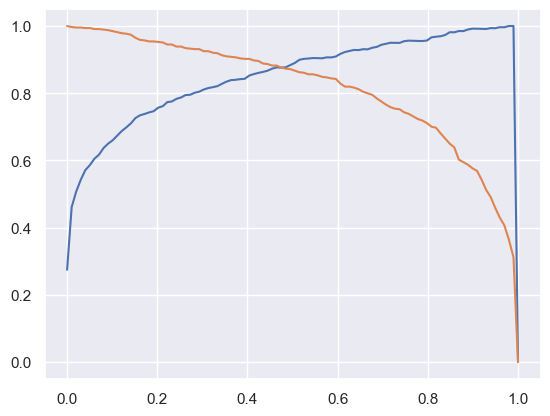

In [21]:
_ = plt.plot(thresholds, precisions)
_ = plt.plot(thresholds, recalls)

##### Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both <br>
Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [22]:
from sklearn.metrics import f1_score

In [23]:
results = {}
for t in thresholds:
    churn_decision = [i[1]>=t for i in y_pred]
    f1 = f1_score(y_val, churn_decision)
    results[t] = f1

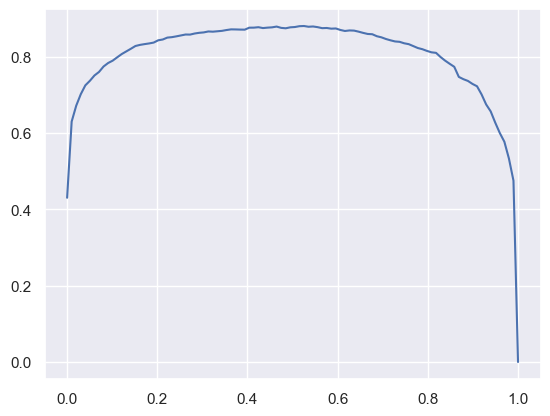

In [24]:
_ = plt.plot(results.keys(), results.values())

In [25]:
[k for k, v in results.items() if v == max(results.values())]

[0.5252525252525253]

##### Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds<br>
How large is standard devidation of the scores across different folds?

In [26]:
from sklearn.model_selection import KFold

In [27]:
def train_pipeline(df_train, y_column, C=1.):
    # split df
    X_train, y_train = x_y_split_and_index(df_train, y_column)
    # OHE
    train_dicts = X_train.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)
    # model fit
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

def predict_pipeline(df, y_column, dv_obj, model_obj):
    X, y = x_y_split_and_index(df, y_column)
    dicts = X.to_dict(orient='records')
    X = dv_obj.transform(dicts)
    y_pred = model_obj.predict_proba(X)[:, 1]

    return y, y_pred

In [28]:
scores_kfold = []
folds = KFold(n_splits=5, shuffle=True, random_state=1)
for train, val in folds.split(df_train_val):
    df_train = df_train_val.iloc[train]
    df_val = df_train_val.iloc[val]

    dv, model = train_pipeline(df_train, 'above_average', C=1.)
    y_val, y_pred = predict_pipeline(df_val, 'above_average', dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores_kfold.append(auc)

In [29]:
np.std(scores_kfold)

0.0027788555134721344

##### Question 6: Hyperparemeter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C
<br><br>
Iterate over the following C values: [0.01, 0.1, 0.5, 10]<br>
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)<br>
Which C leads to the best mean score?

In [30]:
results = {}

for c in [0.01, 0.1, 0.5, 10]:
    folds = KFold(n_splits=5, shuffle=True, random_state=1)
    scores_kfold_c = []
    for train, val in folds.split(df_train_val):
        df_train = df_train_val.iloc[train]
        df_val = df_train_val.iloc[val]

        dv, model = train_pipeline(df_train, 'above_average', C=c)
        y_val, y_pred = predict_pipeline(df_val, 'above_average', dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores_kfold_c.append(auc)
    results[c] = scores_kfold

In [31]:
k_fold_c_res = pd.DataFrame.from_dict(results)
k_fold_c_res.agg(['mean', 'std'])

,0.01,0.10,0.50,10.00
mean,0.979104,0.979104,0.979104,0.979104
std,0.003107,0.003107,0.003107,0.003107
